In [96]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset



In [100]:
# Define grid parameters
nx        = 60
dx        = 2*np.pi/nx

# Generate spatial grid
x = np.arange(0, 2*np.pi, dx)
x  = np.round(x, 3)



In [101]:
# Generate a set of curves for training
n_samples = 1000
ht        = 2*np.pi/(n_samples)
vector    = ht*np.arange(0,n_samples)

# Generate two different curves 
zt = np.zeros([2, n_samples, nx])
for i in range(n_samples):
    xtmp = 1*(x-np.ones(len(x))*vector[i])
    zt[0,i, :] = xtmp**2/max(xtmp**2) 
    zt[1,i, :] = np.sin(x-np.ones(len(x))*vector[i])
zt[0,:, :] = zt[0,:, :]*2-1



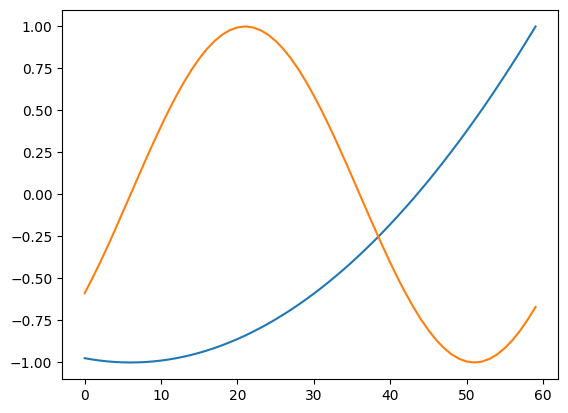

In [102]:
plt.plot(zt[0,100,:])
plt.plot(zt[1,100,:])



In [112]:
# Build training dataset by randomly selecting from zt
vrand = np.random.choice([0, 1], size=n_samples)
z     = np.array([zt[vrand[t],t,:] for t in np.arange(n_samples)])
z     = z[np.random.permutation(np.arange(n_samples)),:]



In [113]:
# Define the model equivalent calculator
def sample_obs(d, idx, tensor=False,perturb=0):
    if tensor:
        n1  = d.size()[0]
        obs = d[torch.arange(d.size(0)).unsqueeze(-1), torch.from_numpy(np.array(idx))]
    else:
        obs = d[idx]
        if perturb>0:
            obs += np.random.normal(0,perturb/2.,len(obs))
    return obs



In [129]:
# Define parameters
n_obs   = 18
obs_err = 0.05

# Get obs locations
random  = [np.random.choice(np.arange(10),size=3,replace=False) for i in np.arange(6)]
obs_idx = (np.array(random)+np.arange(0,60,10)[:,np.newaxis]).flatten()
obs_idx = np.sort(obs_idx)
obs_idx = np.tile(obs_idx,n_samples).reshape((n_samples,n_obs))

# Define the input for the observation values and locations
obs       = np.array([sample_obs(z[it, :], obs_idx[it,:], perturb=obs_err) for it in np.arange(n_samples)])
input_obs = torch.tensor(np.stack((obs,obs_idx/nx)))



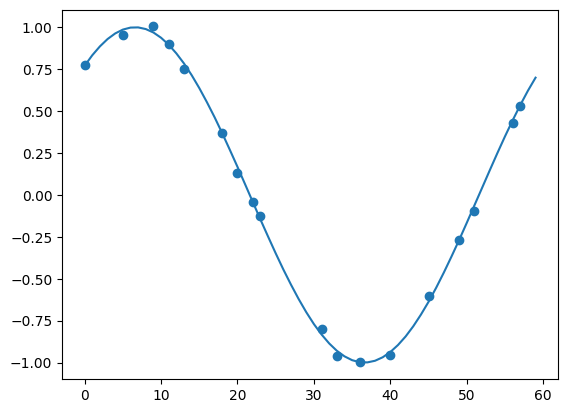

In [131]:
plt.plot(z[100,:])
plt.scatter(obs_idx[100,:],obs[100,:])



In [133]:
# Define the training dataset
class DATrainingDataset(Dataset):
    def __init__(self,input_model,input_obs):
        self.input_model=input_model
        self.input_obs=input_obs

    def __len__(self):
        return self.input_model.shape[0]

    def __getitem__(self,idx):
        fg=self.input_model[idx,:]
        obs=self.input_obs[0,idx,:]
        oidx=self.input_obs[1,idx,:]
        return {"fg":fg,"obs":obs,"idx":oidx,"no":idx}



In [134]:
# Define parameters
batch_size=1024
fac=0.5

# Define the input for first guess
input_model = torch.tensor(fac*z[:,:])

# Initialize training dataset and training loader
train_set = DATrainingDataset(input_model=input_model, input_obs=input_obs)
training_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)



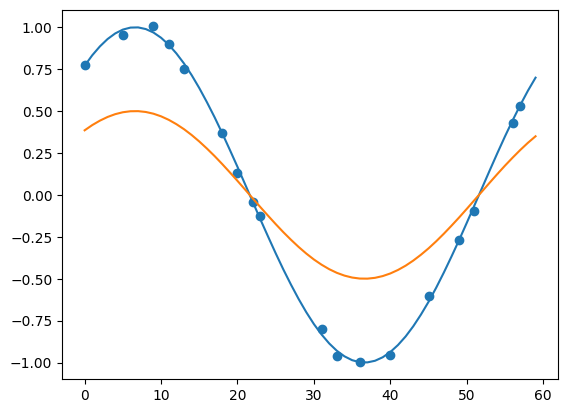

In [135]:
plt.plot(z[100,:])
plt.scatter(obs_idx[100,:],obs[100,:])
plt.plot(input_model.detach().numpy()[100,:])



In [136]:
# Setup the covariance matrix
def calculate_covariance_matrix(x, sigma=1):
    points = np.vstack([x.ravel()]).T
    dist_sq = np.sum((points[:, np.newaxis, :] - points[np.newaxis, :, :]) ** 2, axis=-1)
    covariance_matrix = np.exp(-dist_sq / (2 * sigma ** 2))
    return covariance_matrix

# Calculate the background covariance matrix with regularization
sigma=1.5
b_cov = torch.tensor(calculate_covariance_matrix(x, sigma=sigma))*0.5
lambda_identity = 0.001 * torch.eye(b_cov.shape[0])
regularized_b_cov = b_cov + lambda_identity



In [137]:
# Define the model
class DataAssimilationNN(nn.Module):
    def __init__(self,nx,n_obs):
        super(DataAssimilationNN,self).__init__()
        self.fc1=nn.Linear(nx+2*n_obs,(nx+n_obs)**2) # First hidden layer
        self.fc2=nn.Linear((nx+n_obs)**2,nx)  # Second hidden layer
        self.fc3=nn.Linear(nx,nx) # Output layer

    def forward(self,xin):
        x = torch.cat((xin["fg"].float(), xin["obs"].float(), xin["idx"].float()),dim=1)
        x = torch.tanh(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x.view(-1,nx).double()



In [138]:
# Define the loss function
class DataAssimilationLoss(nn.Module):
    def __init__(self, b_matrix=None,nx=None,obs_err=None):
        super(DataAssimilationLoss,self).__init__()
        self.b_matrix=b_matrix
        self.nx=nx
        self.obs_err=obs_err

    def forward(self,ana_inc,inputs):
        # Calculate distance from background
        inv_b_matrix=torch.inverse(self.b_matrix)
        bg_mismatch=torch.einsum('bi,ij,bj->b',ana_inc,inv_b_matrix,ana_inc).mean()/len(ana_inc)
        # Calculate distance from observations
        o_idx = (inputs["idx"]*nx).numpy().astype(int)
        y_hat=sample_obs(ana_inc.double(), o_idx, tensor=True)
        obs_mismatch=torch.mean((y_hat-inputs["obs"])**2)/((self.obs_err**2)*inputs["obs"].shape[1])
        # Calculate total loss
        total_loss=bg_mismatch+obs_mismatch
        return total_loss,bg_mismatch,obs_mismatch



In [139]:
# Setup for Training
model = DataAssimilationNN(nx, n_obs) # Set up the model
criterion = DataAssimilationLoss(b_matrix=regularized_b_cov, nx=nx, obs_err=obs_err) # Loss function
optimizer = optim.Adam(model.parameters(), lr=0.0025) # Initialize optimizer

# Define the number of training epochs.
num_epochs = 1000
train_loss = []



In [140]:
# Training loop
for epoch in range(num_epochs):
    for i_batch, train_data in enumerate(training_loader): # Iterate over data loader.
        optimizer.zero_grad()  # Clear gradients
        pred = model(train_data) # Forward pass
        loss, fg_loss, obs_loss = criterion(pred, train_data) # Compute training loss
        loss.backward() # Backward pass
        optimizer.step() # Optimization step (parameter update).
    train_loss.append([loss.item(), fg_loss.item(), obs_loss.item()])
    if (epoch+1) % 20 == 0:
        print('Epoch [{:04d}/{:04d}], '.format(epoch+1,num_epochs)+
              'Loss:      {:12.6f} '.format(train_loss[-1][0])+
                         '{:12.6f} '.format(train_loss[-1][1])+
                         '{:12.6f} '.format(train_loss[-1][2]))



Epoch [0020/1000], Loss:          7.418088     2.250303     5.167785 
Epoch [0040/1000], Loss:          2.945354     1.570370     1.374985 
Epoch [0060/1000], Loss:          0.814474     0.441097     0.373376 
Epoch [0080/1000], Loss:          0.243199     0.146268     0.096931 
Epoch [0100/1000], Loss:          0.109769     0.063325     0.046444 
Epoch [0120/1000], Loss:          0.052472     0.020258     0.032214 
Epoch [0140/1000], Loss:          0.036799     0.011749     0.025049 
Epoch [0160/1000], Loss:          0.033744     0.010363     0.023381 
Epoch [0180/1000], Loss:          0.034473     0.010763     0.023710 
Epoch [0200/1000], Loss:          0.039673     0.014411     0.025261 
Epoch [0220/1000], Loss:          0.057310     0.017873     0.039437 
Epoch [0240/1000], Loss:          0.044590     0.016141     0.028449 
Epoch [0260/1000], Loss:          0.038121     0.013651     0.024470 
Epoch [0280/1000], Loss:          0.039294     0.013798     0.025496 
Epoch [0300/1000], L

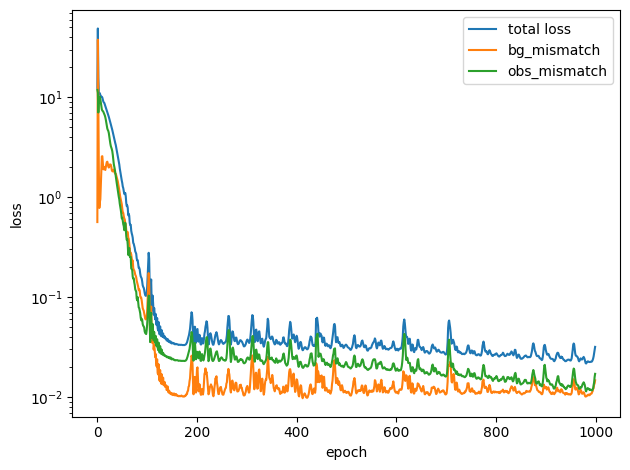

In [146]:
# Loss curve 
plt.plot(np.arange(num_epochs),np.array(train_loss)[:,0],label="total loss")
plt.plot(np.arange(num_epochs),np.array(train_loss)[:,1],label="bg_mismatch")
plt.plot(np.arange(num_epochs),np.array(train_loss)[:,2],label="obs_mismatch")
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.tight_layout()



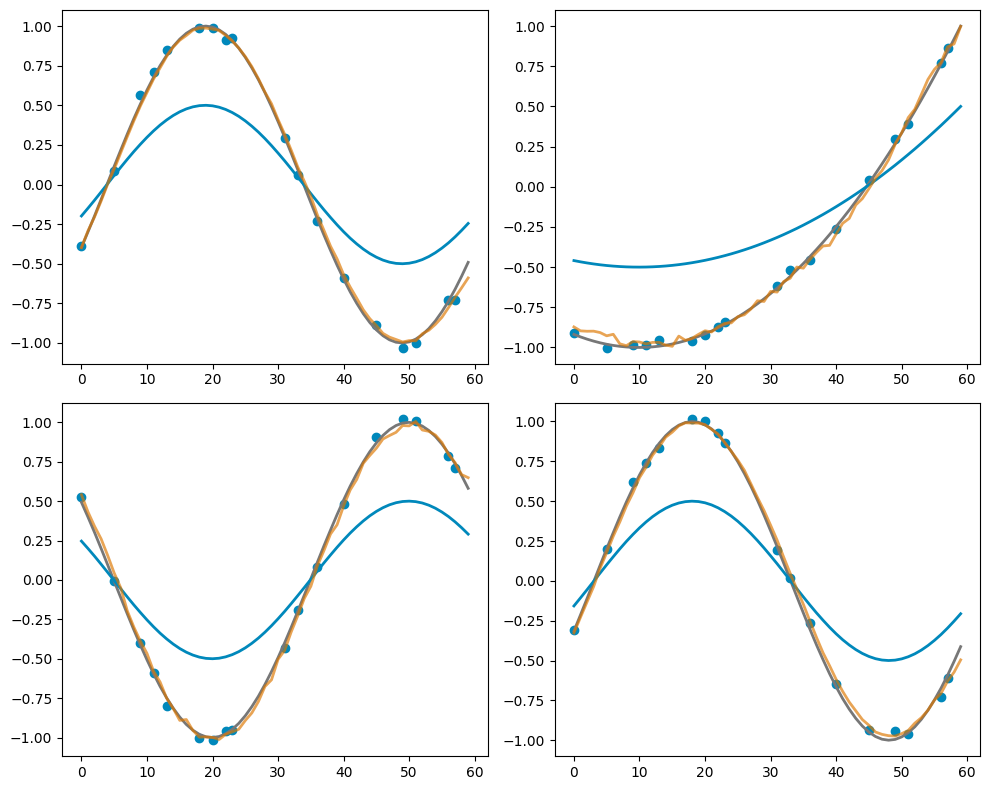

In [141]:
output=model(train_data)
fig,axs=plt.subplots(2, 2, figsize=(10, 8))
for i in np.arange(4):
    ax=axs[int(i/2),i%2]
    ax.plot(z[train_data["no"].detach().numpy()[i*100],:],color="#777777",linewidth=2)
    ax.plot(train_data["fg"].detach().numpy()[i*100,:],color="#0088bb",linewidth=2)
    ax.scatter(train_data["idx"].detach().numpy()[i*100,:]*nx,train_data["obs"].detach().numpy()[i*100,:],color="#0088bb")
    ax.plot(output.detach().numpy()[i*100,:],color="#dd7700aa",linewidth=2)
fig.tight_layout()

